In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pylab as plt
from fiona.crs import from_epsg
from geopandas import GeoDataFrame
import statsmodels.api as sm
import shapely
import pysal as ps
import seaborn as sn
from matplotlib import colors
import urllib
import urllib2
import os
import json
from datetime import datetime
import seaborn as sns
sns.set_style("white")
from timeit import timeit

# census tracts

In [136]:
ct = GeoDataFrame.from_file('nyct2010.shp')

In [137]:
ct = ct.to_crs(epsg=2263)

# bus routes

In [4]:
routes = GeoDataFrame.from_file('routes_bus_nyc_jan2017.shp')

In [5]:
bad_routes = routes[(routes.route_id.isin(['Q113', 'B41', 'B46','B49', 'B44', 'B35']))].copy()

In [6]:
good_routes = routes[(routes.route_id.isin(['Q65', 'BX6', 'BX12','BX35', 'Q25', 'BX15']))].copy()

(140000, 260000)

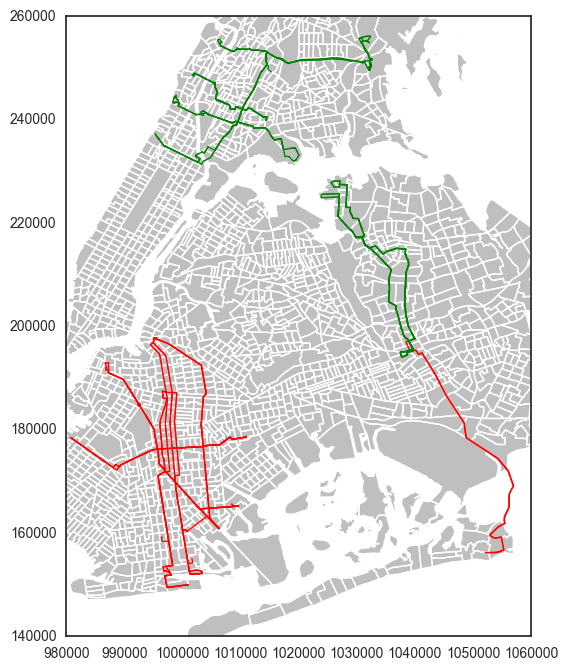

In [250]:
fig = plt.figure(figsize=(6,8))
ax = fig.add_subplot(111)
ct.plot(color='gray', ax=ax, edgecolor='white')
bad_routes.plot(color='r', ax=ax)
good_routes.plot(color='green', ax=ax)
ax.set_xlim([980000,1060000])
ax.set_ylim([140000,260000])

# define bus boundaries and where the cab data is in the NYC open data

In [8]:
# top_left, bottom_right
bus_boundaries = {'q113': [40.713765, -73.716070, 40.592908, -73.812201],
                 'b41': [40.696409, -73.902422, 40.607809, -73.991626],
                 'b44': [40.712008, -73.926141,40.582871, -73.967511]}
nyc_boundaries = [40.917577, -73.700009, 40.477399, -74.25909]

In [9]:
greencab_data = {'2013': 'h4pe-ymjc',
                 '2014': '7j25-xd5y',
                 '2015': 'utt9-dvgj'}

In [10]:
cols = ['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude',
        'trip_distance', 'lpep_pickup_datetime', 'lpep_dropoff_datetime']

## def function to pull data via API

In [11]:
def getrequest(year, busroute):
    base = 'https://data.cityofnewyork.us/resource/'
    year = greencab_data[str(year)]
    key = 'YktpzlGQjMdv9lNPMautBZge7'
    key1 = 'KX8I2ljjXNe81YWprwLkJlUI1xQ8ZcTVPgh3'
    minlat = bus_boundaries[busroute][2]
    maxlat = bus_boundaries[busroute][0]
    minlong = bus_boundaries[busroute][3]
    maxlong = bus_boundaries[busroute][1]
    dropoff_long = '(dropoff_longitude%20%3C%20'+str(maxlong)+'%20AND%20dropoff_longitude%20%3E%20'+str(minlong)+'%20AND%20'
    dropoff_lat = 'dropoff_latitude%20%3C%20'+str(maxlat)+'%20AND%20dropoff_latitude%20%3E%20'+str(minlat)+')%20OR%20' #OR
    pickup_long = '(pickup_longitude%20%3C%20'+str(maxlong)+'%20AND%20pickup_longitude%20%3E%20'+str(minlong)+'%20AND%20'
    pickup_lat = 'pickup_latitude%20%3C%20'+str(maxlat)+'%20AND%20pickup_latitude%20%3E%20'+str(minlat)+')'
    
    req = base+year+'.json?$$app_token='+key+'&$where='+dropoff_long+dropoff_lat+pickup_long+pickup_lat+'&$limit=1000000'  
    return req

def createDf(req, cols):
    response = urllib2.urlopen(req)
    data = json.loads(response.read())
    df = pd.DataFrame(data)
    df = df[cols].copy()
    return df

## let's pull data. WARNING: this takes > 10 minutes

In [12]:
q113_13 = createDf(getrequest(2013,'q113'), cols)
q113_14 = createDf(getrequest(2014,'q113'), cols)
q113_15 = createDf(getrequest(2015,'q113'), cols)

In [ ]:
print len(q113_13)
print len(q113_14)
print len(q113_15)

## def function to merge data and get separate data for pickup/dropoff in that area

In [14]:
def mergeDf(listdf):
    allyear = pd.concat(listdf)
    for col,i in zip(['pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], range(4)):
        allyear[col] = allyear[col].astype(float)
        allyear = allyear[(allyear[col]<nyc_boundaries[i%2])&(allyear[col]>nyc_boundaries[i%2+2])]
    allyear.trip_distance = allyear.trip_distance.astype(float)
    allyear.lpep_pickup_datetime = allyear.lpep_pickup_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000'))
    allyear.lpep_dropoff_datetime = allyear.lpep_dropoff_datetime.apply(lambda x: datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.000'))
    allyear['month'] = allyear['lpep_pickup_datetime'].dt.month
    allyear['year'] = allyear['lpep_pickup_datetime'].dt.year
    return allyear

def inner(df, busroute, key):
    if key == 'pickup':
        for col,i in zip(['pickup_latitude','pickup_longitude'], range(2)):
            df = df[(df[col]<bus_boundaries[busroute][i%2])&(df[col]>bus_boundaries[busroute][i%2+2])]
    else:
        for col,i in zip(['dropoff_latitude','dropoff_longitude'], range(2)):
            df = df[(df[col]<bus_boundaries[busroute][i%2])&(df[col]>bus_boundaries[busroute][i%2+2])]
    return df

### merge datasets. This takes > 5 minutes

In [15]:
q113 = mergeDf([q113_13, q113_14, q113_15])

In [16]:
len(q113)

843673

## def function to convert lat lon to points in NAD

In [17]:
def createPoints(df, lon_column, lat_column):
    df['lonlat'] = zip(df[lon_column], df[lat_column])
    df['geometry'] = df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
    gdf = GeoDataFrame(df)
    gdf.crs = from_epsg(4326)
    return gdf.to_crs(epsg=2263)

### create points dataframe for each pickup and dropoffs. Here we also pick samples

In [18]:
q113.index = range(len(q113))

In [19]:
q113_pickup_inner = inner(q113, 'q113', 'pickup').reset_index()
q113_dropoff_inner = inner(q113, 'q113', 'dropoff').reset_index()

In [20]:
ix_pickup = np.unique(np.random.randint(1, len(q113_pickup_inner), 100000))
ix_dropoff = np.unique(np.random.randint(1, len(q113_dropoff_inner), 100000))

In [95]:
q113_pickup_sample = createPoints(q113_pickup_inner.loc[ix_pickup,['index','pickup_longitude','pickup_latitude']].copy(), 'pickup_longitude', 'pickup_latitude')
q113_dropoff_sample = createPoints(q113_dropoff_inner.loc[ix_dropoff,['index','dropoff_longitude','dropoff_latitude']].copy(), 'dropoff_longitude', 'dropoff_latitude')

In [40]:
q113_ct = ct[ct.geometry.intersects(bad_routes.ix[438].geometry)]

In [65]:
q113_pickup_sample.head()

,index,pickup_longitude,pickup_latitude,lonlat,geometry
1,1,-73.807358,40.700176,"(-73.8073577881, 40.700176239)",POINT (1037665.807738011 194428.2836087035)
5,6,-73.787979,40.641430,"(-73.787979126, 40.6414299011)",POINT (1043090.914470294 173037.7960480683)
6,13,-73.807640,40.700520,"(-73.8076400757, 40.7005195618)",POINT (1037587.260518908 194553.1939924025)
13,35,-73.807709,40.699978,"(-73.8077087402, 40.6999778748)",POINT (1037568.654573065 194355.799972055)
14,44,-73.799416,40.702389,"(-73.7994155884, 40.7023887634)",POINT (1039866.170258923 195239.3129693505)


## Now, intersect those sample points to census tracts

### 1. Intersect pickups. Takes 20 mins

In [72]:
ix_pickup_sample_intersect_full = [] 
for ix in q113_pickup_sample.index:
    for ctname, cts in zip(q113_ct.BoroCT2010,q113_ct.geometry):
        if cts.contains(q113_pickup_sample.ix[ix].geometry):
            ix_pickup_sample_intersect.append([ix,ctname])
    print '\r',"%",str(ix*100./389548)[:4],

% 100.


In [87]:
q113_pickup_sample_intersect_pickup = q113_pickup_sample.ix[[x[0] for x in ix_pickup_sample_intersect]]

In [88]:
q113_pickup_sample_intersect_pickup['ct'] = [x[1] for x in ix_pickup_sample_intersect]

In [96]:
q113_pickup_sample_intersect_pickup.head()

,index,pickup_longitude,pickup_latitude,lonlat,geometry,ct
14,44,-73.799416,40.702389,"(-73.7994155884, 40.7023887634)",POINT (1039866.170258923 195239.3129693505),4024600
101,356,-73.795914,40.705177,"(-73.7959136963, 40.7051773071)",POINT (1040834.773430007 196257.5028939812),4044601
316,1160,-73.801544,40.705620,"(-73.8015441895, 40.705619812)",POINT (1039273.305741218 196415.1333493419),4044601
349,1257,-73.800064,40.702496,"(-73.8000640869, 40.702495575)",POINT (1039686.272140641 195277.8164234554),4024000
427,1619,-73.795815,40.702801,"(-73.7958145142, 40.7028007507)",POINT (1040864.290782251 195391.7187125978),4024600


### 2. Intersect dropoffs
Prepare the data first

In [92]:
q113_pickup_sample_intersect_dropoff = q113.ix[q113_pickup_sample_intersect_pickup['index']]

In [97]:
q113_pickup_sample_intersect_dropoff = createPoints(q113_pickup_sample_intersect_dropoff[['dropoff_longitude','dropoff_latitude']].copy(), 'dropoff_longitude', 'dropoff_latitude')

In [98]:
q113_pickup_sample_intersect_dropoff.head()

,dropoff_longitude,dropoff_latitude,lonlat,geometry
44,-73.799416,40.702389,"(-73.7994155884, 40.7023887634)",POINT (1039866.170258923 195239.3129693505)
356,-73.795914,40.705189,"(-73.7959136963, 40.7051887512)",POINT (1040834.763715979 196261.6723084259)
1160,-73.806473,40.714890,"(-73.8064727783, 40.7148895264)",POINT (1037899.359887172 199789.3048209418)
1257,-73.768150,40.661896,"(-73.7681503296, 40.661895752)",POINT (1048574.137167915 180507.98672877)
1619,-73.756546,40.660583,"(-73.7565460205, 40.6605834961)",POINT (1051794.945537213 180038.6314980212)


### code below is to intersect dropoffs. Because we run for loop for the whole census tracts, this takes >> 1 hr (for ~7000 points)

In [100]:
ix_pickup_sample_intersect_dropoff = [] 
for ix in q113_pickup_sample_intersect_dropoff.index:
    for ctname, cts in zip(ct.BoroCT2010,ct.geometry):
        if cts.contains(q113_pickup_sample_intersect_dropoff.ix[ix].geometry):
            ix_pickup_sample_intersect_dropoff.append([ix,ctname])
    print '\r',"%",str(ix*100./843666)[:4],

% 100.


### number of pickups and dropoffs lies in the nearest census tracts

In [102]:
len(q113_pickup_sample_intersect_dropoff)

7616

In [101]:
len(ix_pickup_sample_intersect_dropoff)

7507

### merge dropoff and pickup

In [109]:
for k,ct in zip([x[0] for x in ix_pickup_sample_intersect_dropoff], [x[1] for x in ix_pickup_sample_intersect_dropoff]):
    q113_pickup_sample_intersect_dropoff.loc[k,'ct'] = ct

In [116]:
q113_pickup_sample_intersect_pickup.index = q113_pickup_sample_intersect_pickup['index']

In [113]:
len(q113_pickup_sample_intersect_dropoff)

7616

In [117]:
q113_pickup_sample_ct = pd.DataFrame({'pickup':q113_pickup_sample_intersect_pickup.ct,
                                     'dropoff':q113_pickup_sample_intersect_dropoff.ct})

In [118]:
q113_pickup_sample_ct.head()

,dropoff,pickup
index,,
44,4024600,4024600
356,4044601,4044601
1160,4045000,4044601
1257,4032000,4024000
1619,4069000,4024600


In [122]:
q113_pickup_sample_ct['trip_distance']=q113.ix[q113_pickup_sample_ct.index]['trip_distance']
q113_pickup_sample_ct['month']=q113.ix[q113_pickup_sample_ct.index]['month']
q113_pickup_sample_ct['year']=q113.ix[q113_pickup_sample_ct.index]['year']

### visualize the pickup

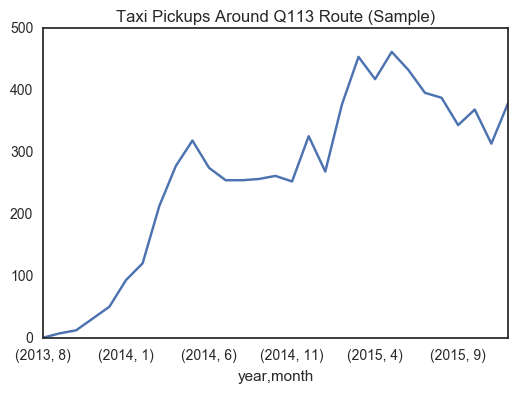

In [238]:
q113_pickup_sample_ct.groupby(['year','month']).count()['trip_distance'].plot()
plt.title("Taxi Pickups Around Q113 Route (Sample)")

In [247]:
q113_pickup_sample_ct.groupby(['year']).count()['pickup']

year
2013     105
2014    2908
2015    4603
Name: pickup, dtype: int64

array([ 2013. ,  2013.5,  2014. ,  2014.5,  2015. ])

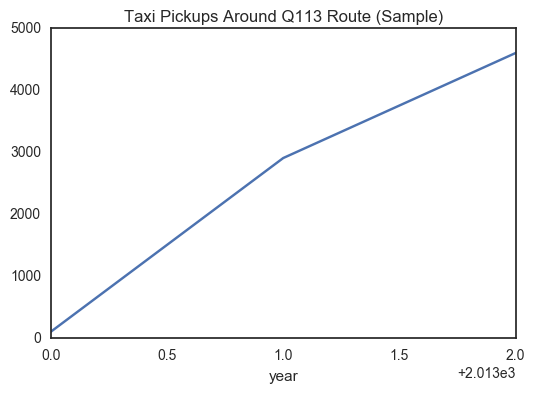

In [244]:
ax = q113_pickup_sample_ct.groupby(['year']).count()['trip_distance'].plot()
ax.set_title("Taxi Pickups Around Q113 Route (Sample)")
ax.get_xticks()

In [241]:
ax.get_xticks()

array([ 2013. ,  2013.5,  2014. ,  2014.5,  2015. ])

### mean and std of trip distance

In [126]:
q113_pickup_sample_ct['trip_distance'].mean()

3.9753650210083964

In [127]:
q113_pickup_sample_ct['trip_distance'].std()

4.169061227039633

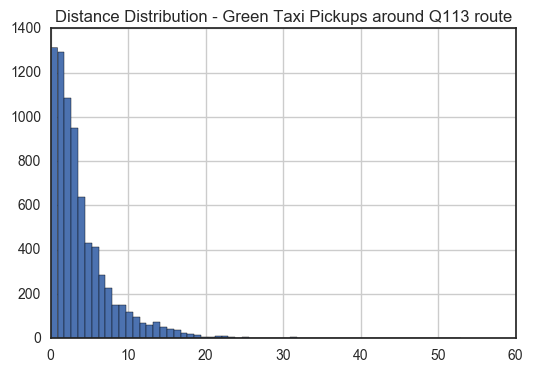

In [156]:
q113_pickup_sample_ct['trip_distance'].hist(bins=60)
plt.title("Distance Distribution - Green Taxi Pickups around Q113 route")

In [157]:
len(q113_pickup_sample_ct)

7616

In [143]:
q113_pickup_sample_ct.groupby('dropoff').count()['trip_distance'].sort_values(ascending=False).head()

dropoff
4024000    226
4020800    204
4025400    199
4044601    196
4071600    163
Name: trip_distance, dtype: int64

In [151]:
q113_pickup_sample_inner = q113_pickup_sample_ct[q113_pickup_sample_ct.dropoff.isin(q113_ct['BoroCT2010'])]

### how many pickups from Q113 area are actually end in that area (along Q113 route) as well? 20%

In [154]:
len(q113_sample_inner)*1./len(q113_pickup_sample_ct)

0.20483193277310924

In [159]:
ct.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001951929,..."
1,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405265 155637.1314207711,..."
2,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.5070190445 214848.8975950923,..."
3,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861339 216013.1308104306,..."
4,1010200,1,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845708 216507.68702381, 9..."


In [144]:
q113_pickup_sample_ct.groupby('pickup').count()['trip_distance'].sort_values(ascending=False).head()

pickup
4024000    2978
4044601    1702
4023600     707
4024600     671
4025400     383
Name: trip_distance, dtype: int64

In [105]:
q113.to_crs(epsg=2263).to_file(driver='ESRI Shapefile',filename='q113.shp')

Exception KeyboardInterrupt: KeyboardInterrupt() in <bound method Point.__del__ of <shapely.geometry.point.Point object at 0x00000000A10AAC88>> ignored


AttributeError: 'DataFrame' object has no attribute 'to_crs'

# visualize in map

In [ ]:
q113.groupby(['year','month']).count()['trip_distance'].plot()

In [ ]:
a = []
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

In [108]:
q113.to_csv('q113.csv')
q113_pickup_inner.to_csv('q113_pickup_inner.csv')
q113_dropoff_inner.to_csv('q113_dropoff_inner.csv')
q113_pickup_sample_intersect_pickup.to_csv('q113_pickup_sample_intersect_pickup.csv')


In [232]:
q113_pickup_sample_ct.to_csv('q113_pickup_sample_ct.csv')

In [166]:
pc=q113_pickup_sample_ct.groupby('pickup').count()['trip_distance'].sort_values(ascending=False).reset_index()

In [167]:
do=q113_pickup_sample_ct.groupby('dropoff').count()['trip_distance'].sort_values(ascending=False).reset_index()

In [212]:
do.columns=['BoroCT2010', 'n_dropoff']

In [171]:
pc.columns=['BoroCT2010', 'n_pickup']

In [175]:
pc=pd.merge(pc,ct,on='BoroCT2010',how='inner')[['BoroCT2010','n_pickup','geometry']]

In [213]:
do=pd.merge(do,ct,on='BoroCT2010',how='inner')[['BoroCT2010','n_dropoff','geometry']]

(1035000.0, 1065000.0, 150000.0, 200000.0)

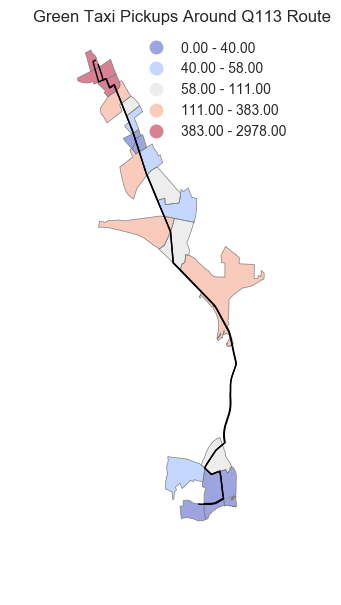

In [227]:
fig = plt.figure(figsize=(3,7))
ax = fig.add_subplot(111)
GeoDataFrame(pc).plot(scheme='quantiles',column='n_pickup',colormap='coolwarm',ax=ax, edgecolor='gray', linewidth=0.5, legend=True)
bad_routes.ix[[438,439]].plot(ax=ax, color='k')
ax.set_title("Green Taxi Pickups Around Q113 Route")
plt.axis('off')

(940000.0, 1080000.0, 140000.0, 280000.0)

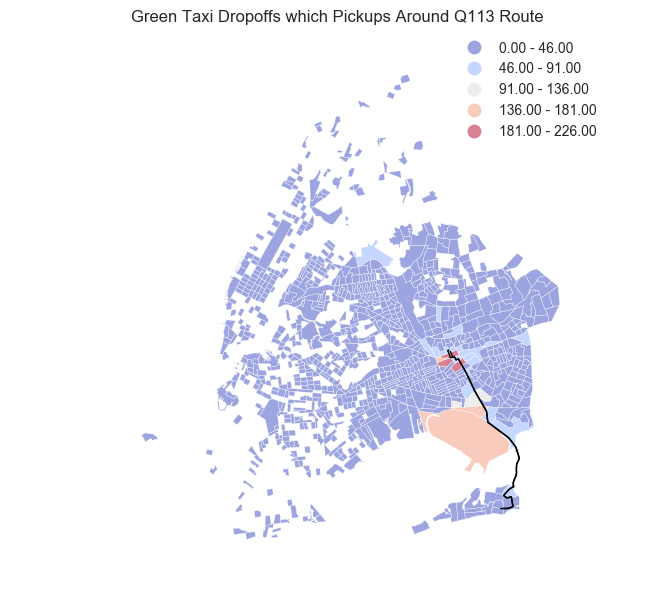

In [234]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
GeoDataFrame(do).plot(scheme='equal_interval',k=5,column='n_dropoff',colormap='coolwarm',ax=ax, edgecolor='white', linewidth=0.2, legend=True)
bad_routes.ix[[438,439]].plot(ax=ax, color='k')
ax.set_title("Green Taxi Dropoffs which Pickups Around Q113 Route")
plt.axis('off')

In [223]:
do['n_dropoff'].sum()

7507L

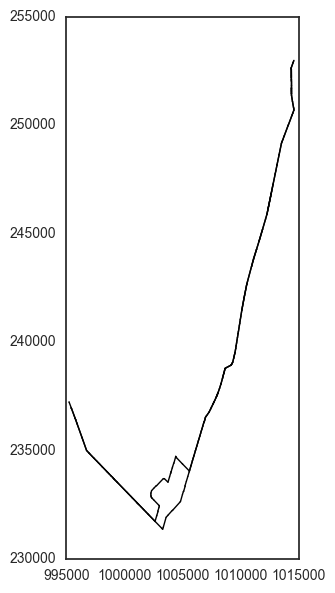

In [254]:
fig = plt.figure(figsize=(3,7))
ax = fig.add_subplot(111)
good_routes.ix[[129,130]].plot(ax=ax, color='k')

In [256]:
bx15_rt = good_routes.ix[[129,130]].copy()

In [260]:
bx15_rt = bx15_rt.to_crs(epsg='4326')

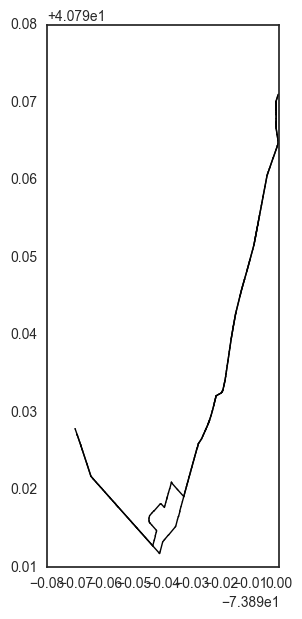

In [261]:
fig = plt.figure(figsize=(3,7))
ax = fig.add_subplot(111)
bx15_rt.plot(ax=ax, color='k')

In [263]:
ax.get_xticks()

array([-73.97, -73.96, -73.95, -73.94, -73.93, -73.92, -73.91, -73.9 ,
       -73.89])

In [264]:
ax.get_yticks()

array([ 40.79,  40.8 ,  40.81,  40.82,  40.83,  40.84,  40.85,  40.86,
        40.87,  40.88])

In [2]:
7507*10/365

205